In [ ]:
import csv
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.metrics import precision_score, f1_score
import os
from gensim.models import Word2Vec
import gensim.downloader as api
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
review=pd.read_csv("/content/drive/MyDrive/nlp_data/review_topic.csv")

Mounted at /content/drive


In [ ]:
review.dropna(inplace=True)
review.head()

,review_id,business_id,stars,text,processed_text,Topic,topic_name
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,if you decide to eat here just be aware it is ...,decide eat aware go take hour begin end try mu...,3,waiting time
1,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,5.0,wow yummy different delicious our favorite is ...,wow yummy different delicious favorite lamb cu...,2,Asian food
2,JrIxlS1TzJ-iCu79ul40cQ,04UD14gamNjLY0IDYVhHJg,1.0,i am a long term frequent customer of this est...,long term frequent customer establishment go o...,3,waiting time
3,_ZeMknuYdlQcUqng_Im3yg,LHSTtnW3YHCeUkRDGyJOyw,5.0,amazingly amazing wings and homemade bleu chee...,amazingly amaze wing homemade bleu cheese ribe...,1,dinner and dessert
4,8JFGBuHMoiNDyfcxuWNtrA,RZtGWDLCAtuipwaZ-UfjmQ,4.0,good foodloved the gnocchi with marinara the b...,good foodloved gnocchi marinara bake eggplant ...,1,dinner and dessert


In [ ]:
review_mod = review.sample(n=250000, random_state=43)
review_mod["sentiment"] = ""
review_mod.loc[review["stars"] >3, "sentiment"] = 1
review_mod.loc[review["stars"] <=3, "sentiment"] = 0
review_mod.head()

,review_id,business_id,stars,text,processed_text,Topic,topic_name,sentiment
19559,vY7DDA2yDLjqJtdE3hw4Mw,LnZvGYbqozanOSevcftnrw,4.0,came here for the first time on a sunday at a...,come first time sunday two friend werent many ...,4,Drinks and staff services,1
646142,Fn44ZXd5kqhXNK-8EJyHQw,3yM-H86cdCHUGW7mwCjE6A,2.0,its good enough when i want a primo hoagie but...,good enough want primo hoagie well primo hoagi...,5,pizza,0
801267,deTVKlp38FtXhS_31uwp_w,6wqxuBt2InDipRuUj8BNuQ,5.0,i live in the bay area and love nothing more t...,live bay area love nothing good strong espress...,4,Drinks and staff services,1
1172529,mWWXwULMA5yXscpS69ypkQ,yxQs5gSf0-8cEd6YMgSjbw,1.0,i came here about a year ago with da homies th...,come year ago da homies absolute shit host mea...,3,waiting time,0
675485,_MCJK_BoOSLChsC5BNzskA,gdyMIBAitsQubj0OEJoiMg,4.0,my friend and i discovered this gem at random ...,friend discover gem random tourist order chees...,0,fastfood like burgers and sandwichs,1


In [ ]:
X = review_mod['processed_text']
y = review_mod.sentiment
y=y.astype('int')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

Word2vec

In [ ]:
word2vec_model=api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def embed_text(word2vec, text):
    embeddings = []
    for word in text:
        if word in word2vec:
            embeddings.append(word2vec[word])
    return np.array(embeddings)

def embed_texts(word2vec, texts):
    embeddings_list = [embed_text(word2vec, text) for text in texts]
    return embeddings_list

def pad_vectors(embeddings_list, maxlen):
    padded_vectors = pad_sequences(embeddings_list, dtype='float32', padding='post', maxlen=maxlen)
    return padded_vectors

def text_to_padded_vectors(word2vec, texts, maxlen):
    embeddings_list = embed_texts(word2vec, texts)
    padded_vectors = pad_vectors(embeddings_list, maxlen)
    return padded_vectors

In [ ]:
from gensim.models.keyedvectors import dtype
max_length=150
X_train_paded=text_to_padded_vectors(word2vec_model,X_train,maxlen=max_length)
X_test_paded=text_to_padded_vectors(word2vec_model,X_test,maxlen=max_length)

In [ ]:
X_train_paded.shape, y_train.shape, X_test_paded.shape, y_test.shape

((200000, 150, 100), (200000,), (50000, 150, 100), (50000,))

LSTM

In [ ]:
model = models.Sequential()
model.add(layers.Masking(mask_value=0, input_shape=(150,100)))
model.add(layers.Bidirectional(layers.LSTM(200, activation='tanh')))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(100, activation="relu"))
model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
#Exponential decay learning rate
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
# set exponential decay learning rate parameters
initial_lr = 0.001
decay_rate = 0.1
decay_steps = 1000

# creat exponential decay function
def lr_scheduler(epoch, lr):
    return lr * decay_rate**(epoch / decay_steps)

lr_decay_callback = LearningRateScheduler(lr_scheduler)

In [ ]:
#earlystop
earlystopping = EarlyStopping(patience=15, restore_best_weights=True, verbose=1)

In [ ]:
history = model.fit(X_train_paded, y_train,
                    validation_split=0.2,
                    epochs = 150,
                    batch_size = 64,
                    verbose = 0,
                    callbacks = [earlystopping])

Restoring model weights from the end of the best epoch: 111.
Epoch 126: early stopping


In [ ]:
res = model.evaluate(X_test_paded, y_test, verbose=0)
print(res[1])

0.8181399703025818


In [ ]:
save_folder = '/content/drive/MyDrive/nlp_data'

In [ ]:
model.save(os.path.join(save_folder, 'lstm_model3.h5'))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from tensorflow.keras.models import load_model
lstm=load_model(os.path.join(save_folder, 'lstm_model3.h5'))

1563/1563 [==============================] - 13s 7ms/step


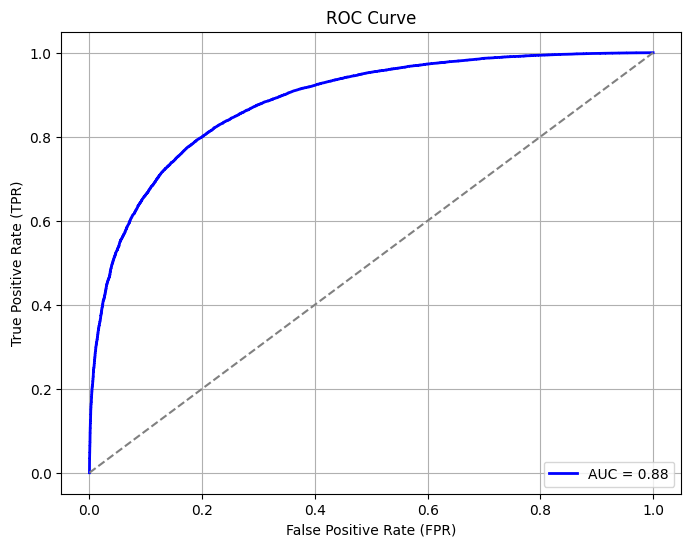

In [ ]:
y_pred_proba = lstm.predict(X_test_paded)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 0])
nb_auc = roc_auc_score(y_test, y_pred_proba[:, 0])

# Draw ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {nb_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
y_pred = lstm.predict(X_test_paded)
y_pred_binary = (y_pred > 0.5).astype(int)
lstm_precision = precision_score(y_test, y_pred_binary)
lstm_f1 = f1_score(y_test, y_pred_binary)
print("Precision:", lstm_precision)
print("F1 Score:", lstm_f1)

1563/1563 [==============================] - 10s 6ms/step
Precision: 0.837109614206981
F1 Score: 0.8686760734247051
